In [8]:
# Plots QC masks for the Parsivel velocity-diameter matrix
# Based on Katja Friedrich's QC routines

import numpy as N
import matplotlib.pyplot as plt
from matplotlib.ticker import *

In [63]:
# Min diameter of bins (mm)
min_diameter_bins = [0.000, 0.125, 0.250, 0.375, 0.500, 0.625, 0.750, 0.875, 1.000, 1.125, 1.250,
                     1.500, 1.750, 2.000, 2.250, 2.500, 3.000, 3.500, 4.000, 4.500, 5.000, 6.000,
                     7.000, 8.000, 9.000, 10.000, 12.000, 14.000, 16.000, 18.000, 20.000, 23.000]
max_diameter_bins = [0.125, 0.250, 0.375, 0.500, 0.625, 0.750, 0.875, 1.000, 1.125, 1.250, 1.500,
                     1.750, 2.000, 2.250, 2.500, 3.000, 3.500, 4.000, 4.500, 5.000, 6.000, 7.000,
                     8.000, 9.000, 10.000, 12.000, 14.000, 16.000, 18.000, 20.000, 23.000, 26.000]

# Average diameter of bins (mm)
avg_diameter_bins = [0.5 * (x + y) for x, y in zip(min_diameter_bins, max_diameter_bins)]


fall_bins = [0.050, 0.150, 0.250, 0.350, 0.450, 0.550, 0.650, 0.750, 0.850, 0.950, 1.100, 1.300,
             1.500, 1.700, 1.900, 2.200, 2.600, 3.000, 3.400, 3.800, 4.400, 5.200, 6.000, 6.800,
             7.600, 8.800, 10.400, 12.000, 13.600, 15.200, 17.600, 20.800]

min_fall_bins = [0.000, 0.100, 0.200, 0.300, 0.400, 0.500, 0.600, 0.700, 0.800, 0.900, 1.000, 1.200,
                 1.400, 1.600, 1.800, 2.000, 2.400, 2.800, 3.200, 3.600, 4.000, 4.800, 5.600, 6.400,
                 7.200, 8.000, 9.600, 11.200, 12.800, 14.400, 16.000, 19.200]

# Parsivel sampling area and sampling period
sensor_area = 0.0054    # (m^2)
sensor_width = 0.03     # (m)
sensor_length = 0.18    # (m)
sampling_period = 10.0  # (s)

min_diameter = N.array(min_diameter_bins)
avg_diameter = N.array(avg_diameter_bins)
max_diameter = N.array(max_diameter_bins)
fall_bins = N.array(fall_bins)
min_fall_bins = N.array(min_fall_bins)

# Jaffrain and Berne (2011), Tokay et al. (2011)
eff_sensor_area = (180. * (30. - avg_diameter / 2.)) * 1.e-6

# Percentage is set by falltol
falltol = 0.6
maskhigh = True
masklow = True

# True to mask out high diameter particles (given by threshold below), False to keep them
maskhighdiam = False
# True to mask out low diameter particles (given by threshold below), False to keep them
masklowdiam = False

highdiamthresh = 9.0
lowdiamthresh = 1.0

def assignfallspeed(d, rhocorrect=False, rho=None):
    """Assigns a fall speed for a range of diameters based on code
       from David Dowell (originally from Terry Schuur).  It appears that
       the formulas originate from Atlas et al. (1973), but this took a bit of sleuthing!"""

    # Note, this appears to be valid at sea level.  For higher altitudes, a fall speed correction
    # should probably be applied based on Foote and duToit (1969): v = v0*(rho0/rho)^(0.4)
    # where rho0 = 1.204 kg/m^3 -- that corresponding to a T of 20 C and pressure of 1013 mb.

    v = N.where(d < 3.0, 3.78 * d**0.67, 9.65 - 10.3 * N.exp(-0.6 * d))
    v = N.where(d < 0.0, 0.0, v)

    # Correct fall speed based on air density
    if(rhocorrect and rho is not None):
        print "rho = ", rho
        v = v * (1.204/rho)**(0.4)

    return v

# Create mask for splashing drops
bottom = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
top = [0, 1, 4, 7, 9, 11, 12, 13, 14, 14, 15, 16, 16, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
splashingmask = [[True if bottom[j] <= i <= top[j]
                  else False for i in range(32)] for j in range(32)]
splashingmask = N.array(splashingmask).T

# Create mask for margin falls
bottom = [0, 8, 14, 17, 20, 21, 22, 23, 24, 25, 26, 26, 27, 27,
          28, 28, 29, 29, 29, 30, 30, 30, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0]
top = N.arange((32), dtype='int')
top[:] = 31
top[23:32] = 0
marginmask = [[True if bottom[j] <= i <= top[j] else False for i in range(32)] for j in range(32)]
marginmask = N.array(marginmask).T

# Create mask for non-raindrops
bottom = [0, 1, 4, 7, 9, 11, 12, 13, 14, 14, 15, 16, 16, 19, 19,
          20, 20, 21, 21, 21, 23, 24, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0]
top = [0, 8, 14, 17, 20, 21, 22, 23, 24, 25, 26, 26, 27, 27, 28,
       28, 29, 29, 29, 30, 30, 30, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0]
rainonlymask = [[False if bottom[j] < i < top[j] else True for i in range(32)] for j in range(32)]
rainonlymask = N.array(rainonlymask).T

# Create mask for non-hail
bottom = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 15, 15, 16, 16, 17, 17, 18, 19, 19, 20, 20, 20]
top = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 24, 25, 25, 31, 32, 32, 32, 32, 32, 32, 32, 32]
hailonlymask = [[False if bottom[j] < i < top[j] else True for i in range(32)] for j in range(32)]
hailonlymask = N.array(hailonlymask).T

# Create mask for all particles with fall speeds outside of fractional tolerance
rainvd = assignfallspeed(avg_diameter)
X, Y = N.meshgrid(rainvd, fall_bins)

if(maskhigh and masklow):
    fallspeedmask = N.where(N.abs((X - Y) / X) < falltol, False, True)
elif(masklow):     # Mask out speeds lower than tolerance
    fallspeedmask = N.where((Y - X) / X < -falltol, True, False)
elif(maskhigh):               # Mask out speeds higher than tolerance
    fallspeedmask = N.where((Y - X) / X > falltol, True, False)
else:
    fallspeedmask = None

# Create mask for strong wind conditions
strongwindmask = N.zeros((32, 32), dtype=bool)
strongwindmask[0:11, 20:32] = True

In [58]:
plot_strongwindQC = False
plot_splashingQC = True
plot_marginQC = True
plot_rainfallspeedQC = False
plot_rainonlyQC = True
plot_hailonlyQC = True

Text(0,0.5,'fall speed (m/s)')

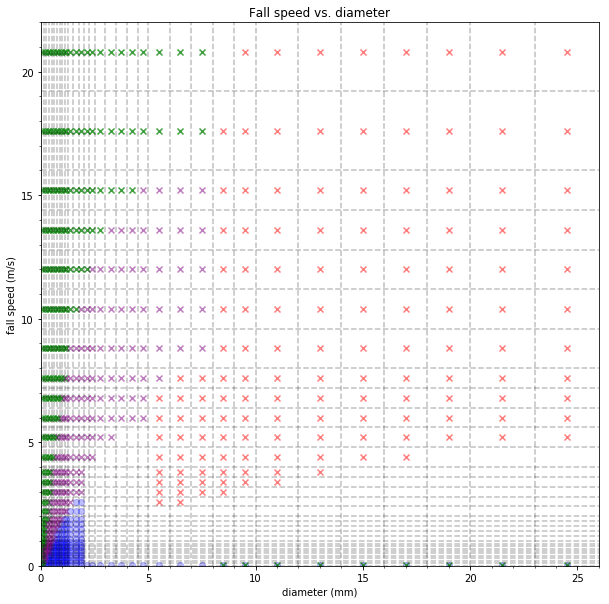

In [65]:
X, Y = N.meshgrid(avg_diameter, fall_bins)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
plt.title('Fall speed vs. diameter')

ax1.vlines(min_diameter, 0.0, 24.0, linestyles='dashed', alpha=0.25)
ax1.hlines(min_fall_bins, 0.0, 26.0, linestyles='dashed', alpha=0.25)

if(plot_strongwindQC):
    ax1.scatter(X[strongwindmask], Y[strongwindmask], c='r', marker='x', alpha=1.0)
if(plot_splashingQC):
    ax1.scatter(X[splashingmask], Y[splashingmask], c='b', marker='o', alpha=0.25)
    # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(splashmask,mask=-splashmask),cmap=cm.Reds,alpha=0.1)
if(plot_marginQC):
    ax1.scatter(X[marginmask], Y[marginmask], c='g', marker='x', alpha=0.75)
    # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(marginmask,mask=-marginmask),cmap=cm.Reds,alpha=0.1)
if(plot_rainfallspeedQC):
    ax1.scatter(X[fallspeedmask], Y[fallspeedmask], c='k', marker='x', alpha=0.5)
    # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(fallspeedmask,mask=-fallspeedmask),cmap=cm.gray,alpha=0.1)
if(plot_rainonlyQC):
    ax1.scatter(X[~rainonlymask], Y[~rainonlymask], c='purple', marker='x', alpha=0.5)
if(plot_hailonlyQC):
    ax1.scatter(X[~hailonlymask], Y[~hailonlymask], c='r', marker='x', alpha=0.5)
    
    
ax1.set_xlim(0.0, 26.0)
ax1.xaxis.set_major_locator(MultipleLocator(5.0))
ax1.xaxis.set_minor_locator(MultipleLocator(1.0))
ax1.set_xlabel('diameter (mm)')
ax1.set_ylim(0.0, 22.0)
ax1.yaxis.set_major_locator(MultipleLocator(5.0))
ax1.yaxis.set_minor_locator(MultipleLocator(1.0))
ax1.set_ylabel('fall speed (m/s)')